## 3.1 决策树的构造

### 3.1.1 信息增益

In [4]:
# 3-1 计算给定数据集的香农熵
from math import log

# 计算香农熵
def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        labelCounts[currentLabel] = labelCounts.get(currentLabel, 0) + 1
    
    shannonEnt = 0
    for key, value in labelCounts.items():
        prob = value / numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [5]:
# 生成样本数据集
def createDataSet():
    dataSet = [
        [1, 1, 'yes'],
        [1, 1, 'yes'],
        [1, 0, 'no' ],
        [0, 1, 'no' ],
        [0, 1, 'no' ]
    ]
    labels = ['不浮出水面是否可以生存', '是否有脚蹼']
    return dataSet, labels

# 增加maybe分类
def createDataSet2():
    dataSet = [
        [1, 1, 'maybe'],
        [1, 1, 'yes'],
        [1, 0, 'no' ],
        [0, 1, 'no' ],
        [0, 1, 'no' ]
    ]
    labels = ['不浮出水面是否可以生存', '是否有脚蹼']
    return dataSet, labels

In [6]:
dataSet, label = createDataSet()
dataSet2, label2 = createDataSet2()
print("两分类香农熵：{}".format(calcShannonEnt(dataSet)))
print("三分类香农熵：{}".format(calcShannonEnt(dataSet2)))

两分类香农熵：0.9709505944546686
三分类香农熵：1.3709505944546687


### 3.1.2 划分数据集

In [7]:
# 3-2 按照给定特征划分数据集
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [8]:
print(splitDataSet(dataSet, 0, 1))
print(splitDataSet(dataSet, 0, 0))

[[1, 'yes'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


In [9]:
# 3-3 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0
    bestFeatures = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)  # 创建唯一的分类标签列表
        newEntropy = 0
        for value in uniqueVals:    # 计算每种划分方式的信息熵
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / len(dataSet)
            newEntropy += prob * calcShannonEnt(subDataSet)  
        infoGain = baseEntropy - newEntropy
        if (infoGain > bestInfoGain):   # 判断最好的信息增益
            bestInfoGain = infoGain
            bestFeatures = i
    return bestFeatures


In [10]:
print("两分类最优划分列：{}".format(chooseBestFeatureToSplit(dataSet)))
print("三分类最优划分列：{}".format(chooseBestFeatureToSplit(dataSet2)))

两分类最优划分列：0
三分类最优划分列：0


### 3.1.3 递归构建决策树（ID3）

In [11]:
# 多数表决确定叶子节点
import operator

def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [50]:
# 3-4 创建树的函数代码
from enum import unique


def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    # 边界条件1：遍历完所有可划分数据集的属性
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    # 边界条件2： 分支下实例都是相同分类
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    bestFeatures = chooseBestFeatureToSplit(dataSet)
    bestFeatLable = labels[bestFeatures]
    tree = {bestFeatLable: {}} 
    featValues = [example[bestFeatures] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subDataSet = splitDataSet(dataSet, bestFeatures, value)
        subFeatLabel = labels[:bestFeatures] + labels[bestFeatures+1:] # 去除当前节点标签以构建子列表
        tree[bestFeatLable][value] = createTree(subDataSet, subFeatLabel)
    return tree  
    

In [51]:
tree = createTree(dataSet, label)
tree2 = createTree(dataSet2, label2)
print("二分类树：{}".format(tree))
print("三分类树：{}".format(tree2))

二分类树：{'不浮出水面是否可以生存': {0: 'no', 1: {'是否有脚蹼': {0: 'no', 1: 'yes'}}}}
三分类树：{'不浮出水面是否可以生存': {0: 'no', 1: {'是否有脚蹼': {0: 'no', 1: 'maybe'}}}}


## 3.2 在Python中使用Matplotlib注解绘制树形图

### 3.2.1 Matplotlib注解

In [14]:
# 3-5 使用文本注解绘制树节点
from re import U
from matplotlib import pyplot as plt

decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode(U'决策节点', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode(U'叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

def plotNode(nodeText, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeText, xy=parentPt, 
                            xycoords='axes fraction', 
                            xytext=centerPt, 
                            textcoords='axes fraction',
                            va='center',
                            ha='center',
                            bbox=nodeType,
                            arrowprops=arrow_args)

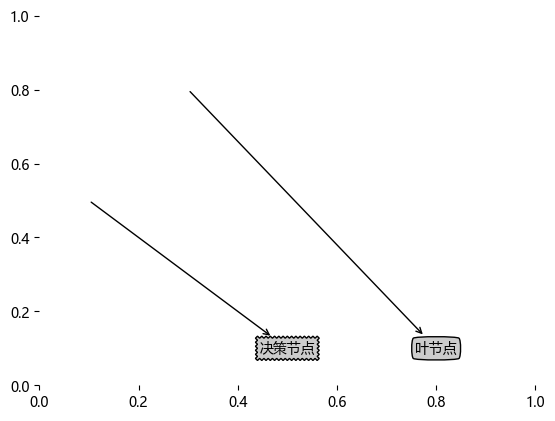

In [15]:
createPlot()

In [21]:
# 获取叶节点的数目和树的层次

def getNumLeafs(tree):
    numLeafs = 0
    firstStr = list(tree)[0]
    secondDict = tree[firstStr]
    for key in secondDict.keys():
        numLeafs += getNumLeafs(secondDict[key]) if type(secondDict[key]).__name__ == 'dict' else 1
    return numLeafs

def getTreeDepth(tree):
    maxDepth = 0
    firstStr = list(tree)[0]
    secondDict = tree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [27]:
print("叶子节点数量：{}".format(getNumLeafs(tree)))
print("树深度：{}".format(getTreeDepth(tree)))

叶子节点数量：3
树深度：2


In [37]:
# 3-7 plotTree函数

def plotMidText(centerPoint, parentPoint, txt):
    xMid = (parentPoint[0] - centerPoint[0]) / 2.0 + centerPoint[0]
    yMid = (parentPoint[1] - centerPoint[1]) / 2.0 + centerPoint[1]
    createPlot.ax1.text(xMid, yMid, txt)

def plotTree(tree, parentPoint, nodeText):
    numLeafs = getNumLeafs(tree)
    depth = getTreeDepth(tree)
    firstStr = list(tree)[0]
    centerPoint = (plotTree.xOff + (1.0 + float(numLeafs)) /2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(centerPoint, parentPoint, nodeText)
    plotNode(firstStr, centerPoint, parentPoint, decisionNode)
    secondDict = tree[firstStr]
    plotTree.yOff -= 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], centerPoint, str(key))
        else:
            plotTree.xOff += 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), centerPoint, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), centerPoint, str(key))
    plotTree.yOff += 1.0 / plotTree.totalD

def createPlot(tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = {
        'xticks': [],
        'yticks': []
    }
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(tree))
    plotTree.totalD = float(getTreeDepth(tree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(tree, (0.5, 1.0), '')
    plt.show()


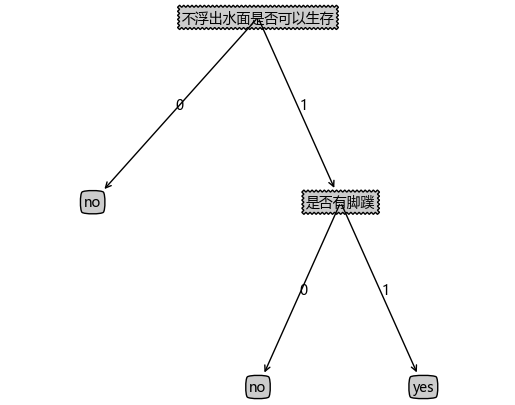

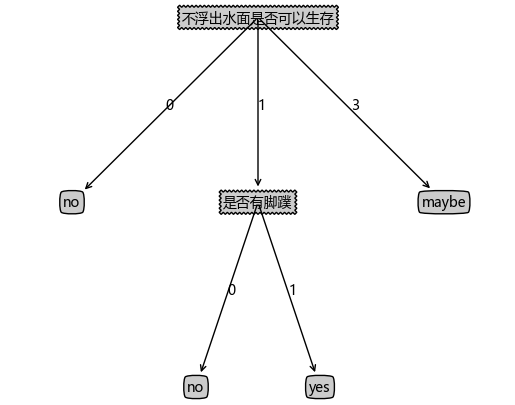

In [49]:
import copy

tree3 = copy.deepcopy(tree)
tree3 ['不浮出水面是否可以生存'][3] = 'maybe'
createPlot(tree)
createPlot(tree3)

## 3.3 测试和存储分类器

### 3.3.1 测试算法：使用决策树执行分类

In [60]:
# 3-8 使用决策树的分类函数
def classifiy(tree, featLabels, testVec):
    firstStr = list(tree)[0]
    secondDict = tree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classifiy(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel


In [61]:
classifiy(tree, label, [1, 0])

'no'

### 3.3.2 使用算法：决策树的存储

In [62]:
# 3-9 使用pickle模块存储决策树
import pickle

def storeTree(tree, filename):
    with open(filename, 'w') as f:
        pickle.dump(tree, f)

def grabTree(filename):
    with open(filename, 'r') as f:
        tree = pickle.load(f)
    return tree

## 3.4 示例：通过决策树预测隐形眼镜类型

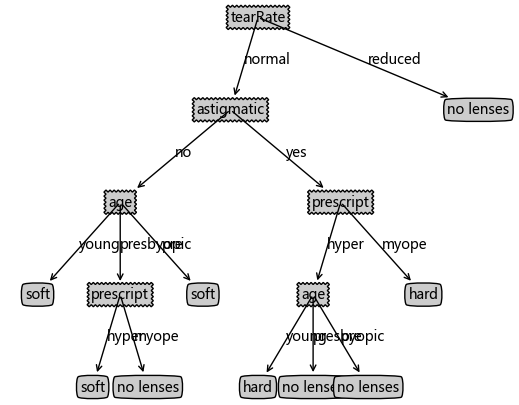

In [63]:
with open('lenses.txt') as f:
    lenses = [inst.strip().split('\t') for inst in f.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
createPlot(lensesTree)


## 附录

[1] [如何理解信息熵-bilibili](https://www.bilibili.com/video/BV1oX4y1w7aG)

[2] [决策树算法--ID3算法-知乎](https://zhuanlan.zhihu.com/p/133846252)